In [1]:
import datasets
from langchain_core.documents import Document as LangchainDocument
from tqdm import tqdm
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

LLM = "google/gemma-2-2b-it"
EMBEDDINGS_MODEL = "thenlper/gte-base"

## Load dataset

Load squad dataset and filter train samples that have more than `400` tokens.

We want to do that because prompt will also contain system prompt and user question so we don't want to exceed model `512` tokens to avoiding prompt truncation.

This will also help a bit during training since, shorter samples meaning faster training and inference.

In [2]:
tokenizer = AutoTokenizer.from_pretrained(LLM)
ds_df = pd.DataFrame(datasets.load_dataset("rajpurkar/squad", split="train")).drop_duplicates(subset='context')
ds = datasets.Dataset.from_pandas(ds_df)
ds = ds.filter(lambda sample: len(tokenizer.encode(sample["context"])) < 400)
ds

Filter:   0%|          | 0/18891 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', '__index_level_0__'],
    num_rows: 18757
})

In [4]:
BASE = [
    LangchainDocument(page_content=document["context"], metadata={"title": document["title"]}) for document in tqdm(ds)
]

docs_num_tokens = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(BASE)]

100%|██████████| 18757/18757 [00:02<00:00, 7211.48it/s]


In [5]:
arr = np.array(docs_num_tokens)

def percentile_count(percentile, arr):
    p = np.percentile(arr, percentile)
    print("-"*20)
    print(f"Percentile p-{percentile}: {p}")
    print(f"Number of samples in the dataset that have length equal or smaller than the percentile: {len(arr[arr <= p])}")

for i in [70, 80, 90, 95, 99]:
    percentile_count(i, arr)

print(f"Max tokens length from LLM tokenizer: {max(arr)}")

--------------------
Percentile p-70: 176.0
Number of samples in the dataset that have length equal or smaller than the percentile: 13229
--------------------
Percentile p-80: 199.0
Number of samples in the dataset that have length equal or smaller than the percentile: 15018
--------------------
Percentile p-90: 238.0
Number of samples in the dataset that have length equal or smaller than the percentile: 16913
--------------------
Percentile p-95: 276.0
Number of samples in the dataset that have length equal or smaller than the percentile: 17842
--------------------
Percentile p-99: 343.0
Number of samples in the dataset that have length equal or smaller than the percentile: 18573
Max tokens length from LLM tokenizer: 399


Text(0.5, 1.0, 'Documents length distribution (in count of LLM tokens)')

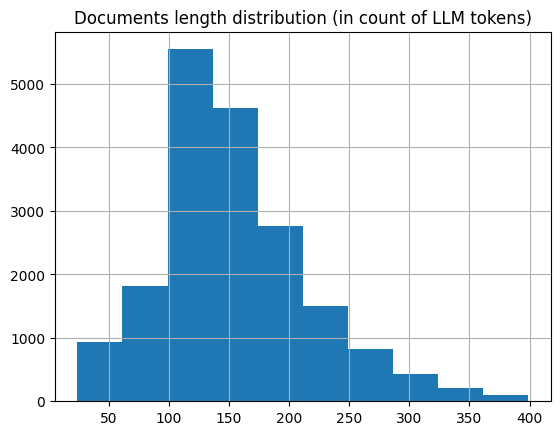

In [6]:
fig = pd.Series(docs_num_tokens).hist()
plt.title("Documents length distribution (in count of LLM tokens)")

## Exploring Embeddings Model

We also have to check if our embeddings model will not truncate context when performing embedding. This is important beacuse if embeddings model will truncate context we may loose important information in our documents thus retreival will not be as effective and accurate.

In [7]:
embeddings_tokenizer = AutoTokenizer.from_pretrained(EMBEDDINGS_MODEL)

In [8]:
doc_embeddings_num_tokens = [len(embeddings_tokenizer.encode(doc.page_content)) for doc in tqdm(BASE)]

100%|██████████| 18757/18757 [00:04<00:00, 4606.06it/s]


In [9]:
embeddings_arr = np.array(doc_embeddings_num_tokens)

for i in [70, 80, 90, 95, 99]:
    percentile_count(i, embeddings_arr)

print(f"Max tokens length from embeddings tokenizer: {max(embeddings_arr)}")

--------------------
Percentile p-70: 172.0
Number of samples in the dataset that have length equal or smaller than the percentile: 13191
--------------------
Percentile p-80: 195.0
Number of samples in the dataset that have length equal or smaller than the percentile: 15046
--------------------
Percentile p-90: 233.0
Number of samples in the dataset that have length equal or smaller than the percentile: 16896
--------------------
Percentile p-95: 268.0
Number of samples in the dataset that have length equal or smaller than the percentile: 17822
--------------------
Percentile p-99: 333.0
Number of samples in the dataset that have length equal or smaller than the percentile: 18571
Max tokens length from embeddings tokenizer: 450


Text(0.5, 1.0, 'Distribution of document lenghts (in embeddings tokens number)')

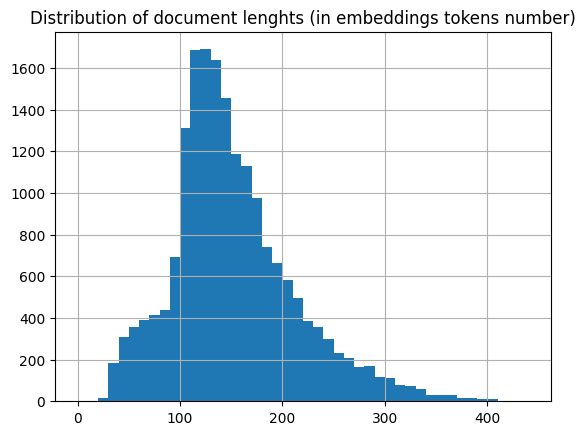

In [10]:
embeddings_fig = pd.Series(embeddings_arr).hist(bins=range(0, max(embeddings_arr), 10))
plt.title("Distribution of document lenghts (in embeddings tokens number)")

## Building Vector Database

In [11]:
doc_store = [
    LangchainDocument(
        page_content=doc['context'],
        metadata={"title": doc['title']}
    ) for doc in tqdm(ds)
]
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDINGS_MODEL,
    show_progress=True,
    multi_process=True,
    encode_kwargs={"normalize_embeddings": True}
)


VECTOR_DB = FAISS.from_documents(
    BASE, embedding_model, distance_strategy=DistanceStrategy.COSINE
)
# VECTOR_DB = FAISS.load_local("faiss_store", embedding_model, allow_dangerous_deserialization=True)

100%|██████████| 18757/18757 [00:00<00:00, 31053.60it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

In [17]:
VECTOR_DB.save_local("faiss_store")

In [12]:
user_query = "Was songs did Beyonce performed?"
q_vector = embedding_model.embed_query(user_query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [13]:
import pacmap
import plotly.express as px

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(VECTOR_DB.index.reconstruct_n(idx, 1)[0]) for idx in range(len(doc_store))
] + [q_vector]

documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/opt/anaconda3/envs/praca/lib/python3.12/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [15]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "symbol": "circle",
            "size_col": 4,
            "title": doc_store[i].metadata['title'],
            "extract": doc_store[i].page_content[:100] + "..."
        }
        for i in range(len(doc_store))
    ] 
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "symbol": "star",
            "size_col": 100,
            "title": "User query",
            "extract": user_query
        }
    ] 
)

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="title",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [18]:
VECTOR_DB.similarity_search("world war", k=20)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Document(metadata={'title': 'Modern_history'}, page_content='Much of the fighting in World War I took place along the Western Front, within a system of opposing manned trenches and fortifications (separated by a "No man\'s land") running from the North Sea to the border of Switzerland. On the Eastern Front, the vast eastern plains and limited rail network prevented a trench warfare stalemate from developing, although the scale of the conflict was just as large. Hostilities also occurred on and under the sea and—for the first time—from the air. More than 9 million soldiers died on the various battlefields, and nearly that many more in the participating countries\' home fronts on account of food shortages and genocide committed under the cover of various civil wars and internal conflicts. Notably, more people died of the worldwide influenza outbreak at the end of the war and shortly after than died in the hostilities. The unsanitary conditions engendered by the war, severe overcrowding 

In [24]:
from transformers import AutoModelForCausalLM
from typing import Tuple
import torch

def get_llm() -> Tuple[AutoTokenizer, AutoModelForCausalLM]:
    tokenizer = AutoTokenizer.from_pretrained(LLM)
    model = AutoModelForCausalLM.from_pretrained(
        LLM,
        torch_dtype=torch.bfloat16,
        device_map='auto',
    )
    return tokenizer, model
    
def apply_prompt(tokenizer: AutoTokenizer):
    template = [
        {
            "role": "user",
            "content": """Context: {context}\nHere is the question you need to answer. Question: {question}"""
        }
    ]
    return tokenizer.apply_chat_template(
        template, tokenize=False, add_generation_prompt=True
    )

tokenizer, model = get_llm()
template = apply_prompt(tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
def concat_context_documents(documents: list) -> str:
    return "".join([f"Document {i}:::\n{doc.page_content}\n" for i, doc in enumerate(documents, 1)])

In [29]:
rag = VECTOR_DB.similarity_search("When did the first World War begin?", k=2)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 